### Notation
Capital leters denote random variables $X$ and lower-case denotes observations $x$;

Capital $P(X)$ denotes the true probablity distribution and $P(x)$ is short-hand for $P(X=x)$;

We use lower case $p$ to denote approximations/models of probability distributions $p(x)$.


# Deep latent variable generative models

Generative modelling aims to model the data distribution from an observed sample. Formally, given a set of observations (sample) $\{x^{(1)}, \ldots, x^{(n)}\}$ of random variable $X$ distributed according to an unknown distribution $X \sim P(X)$, we wish to obtain a parametric probabilistic model $p_\theta$ from which we can generate new samples for distribution and calculate likelihoods  $p_\theta(X=x)$.

When the observed variable is high-dimensional and has a complex structure, simple parametric or linear models are not powerful enough.
Latent variable generative models allow us to represent complex, high-dimensional data distributions through a lower-dimensional, simpler structure. Specifically, we assume that the variation in the observed random variable $X$ is governed by a set of underlying, unobservable latent variables $Z$, which is related to $X$ via a conditional model $P(X \vert Z)$.
We usually choose $Z \sim P(Z)$ to be a simple parametric distribution, such as a normal distribution, and thus the goal is to model $p_\theta(x \vert z)$.

The advantage of this approach is that it provides a compact representation of the complex data distribution, which can be useful for tasks such as data visualization, density estimation, and data synthesis. Additionally, by learning a lower-dimensional representation of the data, latent variable generative models can also capture meaningful patterns and relationships in the data, which can be leveraged for a variety of downstream tasks such as classification, clustering, and generative art.

Usually, the first step in any generative model is to write down the log-likelihood of $X$ as the marginal distribution over latent factors and then use Bayes rule to obtain a conditional model, resulting in the log-expectation over the latent variable.

$\begin{aligned} \log p(x) &= \log \int p(x, z) dz \\ &= \log \int p(x \vert z)p(z) \\ &= \log \mathbb{E}_{z \sim p(z)}\big[p(x \vert z)\big] \end{aligned}$


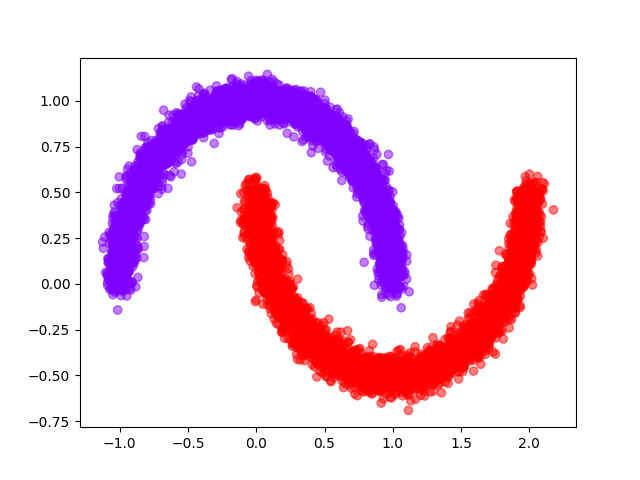

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as datasets
import torch
from torch.utils.data import DataLoader, Dataset, random_split

class MoonsDataset(Dataset):
    def __init__(self, n_samples=10000, noise=0.01):
        X, y = datasets.make_moons(n_samples=10000, noise=noise)
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


ds = MoonsDataset(noise=.05)
n_train, n_val, n_test = 6000, 2000, 2000
train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

plt.scatter(ds.X[:, 0], ds.X[:, 1], c=ds.y, cmap="rainbow", alpha=0.5)
plt.show()

## Monte-Carlo Expectation Maximisation

The Monte-Carlo approximation of the integral is given by:

$\begin{aligned} \log p(x) &= \log \int p(x, z) dz \\ &= \log \int p(x \vert z)p(z) \\ &= \log \mathbb{E}_{z \sim p(z)}\big[p(x \vert z)\big] \\ &\approx \log \frac{1}{M}\sum_{m=1}^{M}p(x \vert z_m), \quad z_m \sim p(z)\end{aligned}$

We can obtain an algorithm by selecting parametric forms for the latent prior $p(z)$ and conditional likelihood $p(x \vert z)$.

For example, we can choose the latent prior to be a standard Gaussian: $p(z) \sim \mathcal{N}(0, 1)$ and the conditional likelihood to be a Gaussian distribution with mean and variance parameterised by a neural network: $p(x|z) \sim \mathcal{N}(\mu_\theta(z), \sigma^2_\theta(z))$.

Using Maximum Likelihood Estimation (MLE) for the model's parameters, we obtain the following objective:

$\theta^* = \begin{aligned}\arg \max_{\theta}\frac{1}{N}\sum_{n=1}^N\log  \frac{1}{M}\sum_{m=1}^M p_\theta(x^{(n)} \vert z^{(m)}) \quad z^{(m)} \sim p(z)\end{aligned}$

We can obtain parameter estimates by using expectation maximisation/mini-batch gradient descent. The loss function is the negative log-likelihood.

4999/5000: Loss 0.601: : 5000it [02:24, 34.69it/s]
/tmp/ipykernel_3302/493829290.py:74: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


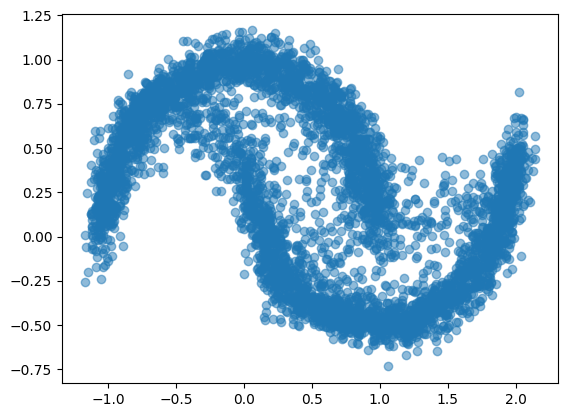

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torch
import torch.optim
from functorch import vmap
from itertools import cycle
from tqdm import tqdm

class MCEM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.prior = torch.distributions.MultivariateNormal(
            loc=torch.zeros((latent_dim,)),
            covariance_matrix=torch.diag_embed(torch.ones((latent_dim,))),
        )
        self.generative_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=input_dim * 2),
        )

    def sample(self, num_samples: int) -> torch.Tensor:
        # Implement a function that return {num_samples} samples from the generative model
        ...

    def loss(self, x: torch.Tensor, num_mc_samples: int = 100) -> torch.Tensor:
        # Implement a function returns the loss (negative log-likelihood of the model)
        ...

    def forward(self, num_samples: int) -> torch.Tensor:
        return self.sample(num_samples)


model = MCEM(input_dim=2, hidden_dim=32, latent_dim=8)
num_steps = 5000
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

pbar = tqdm(zip(range(num_steps), cycle(train_loader)))

for step, (x, y) in pbar:
    optimizer.zero_grad()
    loss = model.loss(x, num_mc_samples=100)
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{step:03d}/{num_steps:03d}: Loss {loss:.3f}")


samples = model(5000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)